# Implementing the "Steiner filter"

The filter (naming it here as "Steiner filter") is described in depth in a study produced the the researchers at the University of Miskolc:
http://midra.uni-miskolc.hu/JaDoX_Portlets/documents/document_16598_section_9413.pdf

Originally this was implemented Octave, but to increase both computational and maintenance effiency the filter has been re-implemented here in Python, with the help of the numpy library.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

%matplotlib notebook

# Test function

The function that we will use with testing is defined as such:

\begin{equation}
u(t) = 
    \begin{cases}
        \kappa t^\eta e^{-\lambda t} \sin(\omega t + \phi)&,  t \ge 0 \\
        0&, t \lt 0
    \end{cases}
\end{equation}

In [2]:
def test_function(t,
                  kappa=738.91,
                  eta=2,
                  lambd=20,
                  omega=40*np.pi,
                  phi=np.pi/4):
    return (np.sign(t)+1)/2*kappa*t**eta*np.exp(-lambd*t)*np.sin(omega*t+phi)

<IPython.core.display.Javascript object>


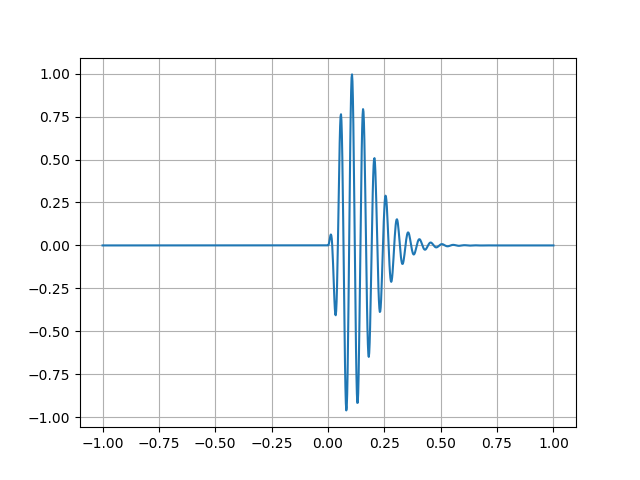

In [3]:
x=np.linspace(-1,1,1024)
u=test_function(x)
test_fig, test_axes = plt.subplots(num='Test Function')
test_axes.plot(x,u)
test_axes.grid()
test_fig.show()

# Mathematical Fourier Transform Implementation

The following functions wrap the FFT algorithm output to produce the mathematical Fourier transform.

To help check results the above defined test function has the following Fourier transform:
\begin{equation}
U(w) = \frac{\kappa \Gamma(\eta+1)}{i 2 \sqrt{2\pi}}
             \left( \frac{\exp(i \phi)}{[i (w-\omega)+\lambda]^{(\eta+1)}}
              - \frac{ \exp(-i \phi)}{[i (w+\omega)+\lambda]^{(\eta+1)}}\right)
\end{equation}

In [4]:
def test_function_fourier(w,
                          kappa=738.91,
                          eta=2,
                          lambd=20,
                          omega=40*np.pi,
                          phi=np.pi/4):
    from scipy.special import gamma
    return (kappa*gamma(eta+1)
            /(2*1j*np.sqrt(2*np.pi))
            *(np.exp(1j*phi)/(1j*(w-omega)+lambd)**(eta+1)
              -np.exp(-1j*phi)/(1j*(w+omega)+lambd)**(eta+1)))

In [5]:
def math_fft(y,x):
    dt = x[1]-x[0]
    f = np.fft.fftfreq(len(x),dt)

    fy = np.fft.fft(y)

    fy = np.fft.fftshift(fy)
    f = np.fft.fftshift(f)

    fy *= np.exp(-1j*2*np.pi*f*x[0])
    
    fy *= dt/np.sqrt(2*np.pi)
    
    return fy,f

## Closeness metric

We define the following metric to check the closeness of two (discretized) function outputs:
\begin{equation}
d[f,g] = \sqrt{\frac{1}{N} \sum_{k=0}^{N} (f_k - g_k)^2 }
\end{equation}

<IPython.core.display.Javascript object>


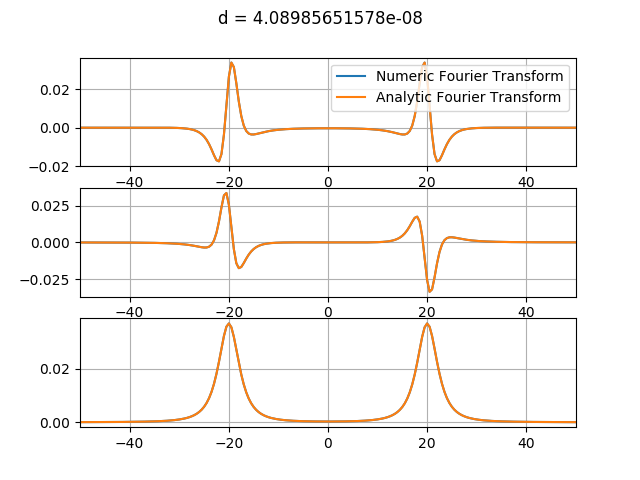

In [38]:
fu,f = math_fft(u,x)
fu_analytic = test_function_fourier(2*np.pi*f)

fft_test_fig,fft_test_axes=plt.subplots(3,num='Test Function FFT')
fft_test_fig.suptitle("d = "+str(np.sqrt(np.mean(np.abs(fu-fu_analytic)**2))))
fft_test_axes[0].plot(f,np.real(fu))
fft_test_axes[0].plot(f,np.real(fu_analytic))
fft_test_axes[0].legend(['Numeric Fourier Transform','Analytic Fourier Transform'])
fft_test_axes[0].grid()
fft_test_axes[0].set_xlim(-50,50)
fft_test_axes[1].plot(f,np.imag(fu))
fft_test_axes[1].plot(f,np.imag(fu_analytic))
fft_test_axes[1].grid()
fft_test_axes[1].set_xlim(-50,50)
fft_test_axes[2].plot(f,np.abs(fu))
fft_test_axes[2].plot(f,np.abs(fu_analytic))
fft_test_axes[2].grid()
fft_test_axes[2].set_xlim(-50,50)
fft_test_fig.show()

# Inverse Mathematical Fourier Transform implementation

In [7]:
def math_ifft(fy,f):
    df = f[1]-f[0]
    x = np.fft.fftfreq(len(f),df)
    x = np.fft.fftshift(x)
    
    y = fy*np.exp(1j*2*np.pi*f*x[0])
    
    y = np.fft.ifftshift(y)

    y = np.fft.ifft(y)
    
    y *= df*len(fy)*np.sqrt(2*np.pi)
    
    return y,x

<IPython.core.display.Javascript object>


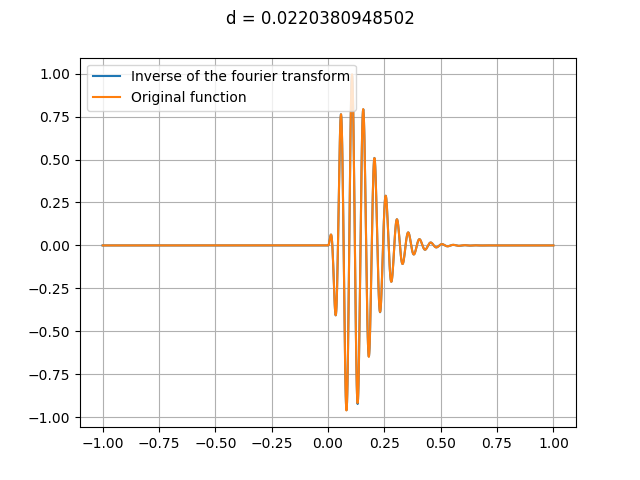

In [37]:
un,xn = math_ifft(fu,f)

ifft_test_fig, ifft_test_axes = plt.subplots(num = 'Test Function Inverse FFT')
ifft_test_fig.suptitle("d = "+str(np.sqrt(np.mean(np.abs(u-np.real(un))**2))))
ifft_test_axes.plot(xn,np.real(un))
ifft_test_axes.plot(x,u)
ifft_test_axes.legend(['Inverse of the fourier transform','Original function'])
ifft_test_axes.grid()
ifft_test_fig.show()

# Hermite Functions

The noise filtering method relies on stored results of [Hermite functions](https://en.wikipedia.org/wiki/Hermite_polynomials#Hermite_functions), which form the eigenfunctions of Fourier transformation.

They have been implemented in the following cells.

In [9]:
def Hermite(n,w,a=1):
    from numpy.polynomial.hermite import Hermite as h
    from scipy.special import gammaln
    
    w_a = np.sqrt(a)*w
    
    return (a**0.25
            *h.basis(n)(w_a)
            *np.exp(-0.5*(w_a)**2
            -0.5*(0.5*np.log(np.pi)+gammaln(n+1)+n*np.log(2))))

Here we demonstrate how Hermite functions with scaling of 1 transform into themselves in Fourier space. (Up to a constant multiplier of $i^{n}$)

Note: In the following demo and later in this notebook we only go up to the $185$th function mainly because of numerical constraints. Above this the "useful" part of the function is withered with overflows, mainly due to the increasingly large power of Hermite polinomials. Without using the $\ln\Gamma$ function in the above equation the overflow would occur because of the factorial at $n=151$

<IPython.core.display.Javascript object>


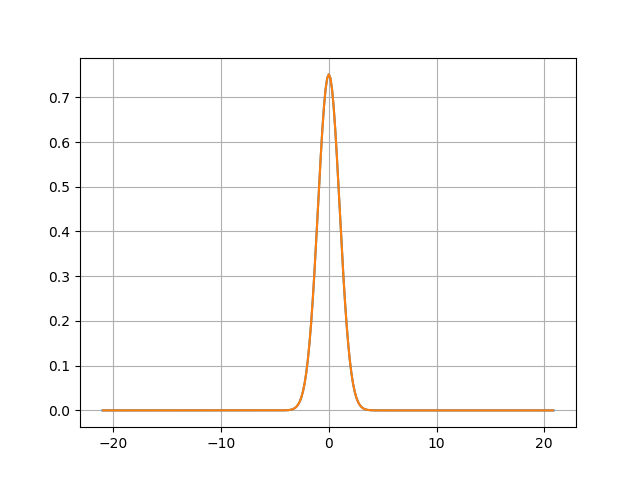

In [10]:
herm_fft_demo_fig,herm_fft_demo_axes = plt.subplots(num = 'Hermite FFT Demo')
def Hermite_fft_demo(n=0):
    a = 1
    t = np.arange(-21,21,0.15)
    herm_fft_demo_axes.cla()
    y = Hermite(n,t,a)
    fy,f = math_fft(y,t)
    fy *= 1j**n
    herm_fft_demo_axes.plot(t,y)
    herm_fft_demo_axes.plot(2*np.pi*f,np.real(fy))
    herm_fft_demo_axes.grid()
    herm_fft_demo_fig.show()

n1_slider = widgets.IntSlider(min=0, max=185, step=1, value=0)
w1=widgets.interactive(Hermite_fft_demo,n=n1_slider)
display(w1)

# Jacobi Matrix

We define the Jacobi matrix that stores these functions.

In [11]:
def Jacobi_Matrix(t,n,a=1):
    G = np.zeros((len(t),n),dtype=np.complex)
    for l in range(n):
        G[:,l] = 1j**l*Hermite(l,t,1/a)
    return G

<IPython.core.display.Javascript object>


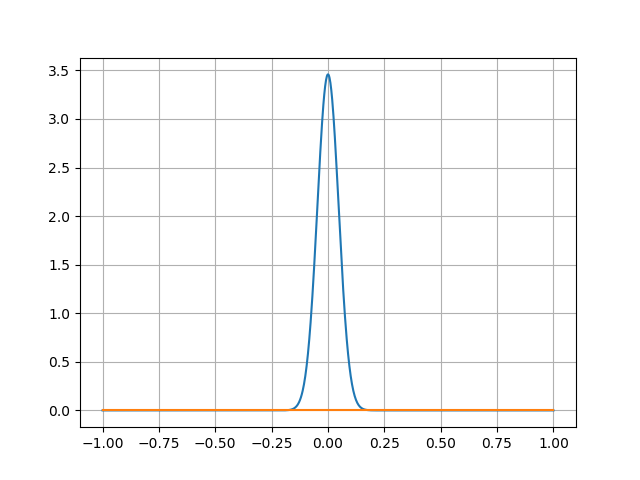

In [12]:
t = np.linspace(-1,1,1024)
M = 186
G = Jacobi_Matrix(t,M,1/450)

jacobi_demo_fig,jacobi_demo_axes=plt.subplots(num='Jacobi Matrix Demo')
def Jacobi_Demo(n=0):
    jacobi_demo_axes.cla()
    jacobi_demo_axes.plot(t,np.real(G[:,n]),'-')
    jacobi_demo_axes.plot(t,np.imag(G[:,n]),'-')
    jacobi_demo_axes.grid()
    jacobi_demo_fig.show()

n2_slider = widgets.IntSlider(min=0, max=G.shape[1]-1, step=1, value=0)
w2=widgets.interactive(Jacobi_Demo,n=n2_slider)
display(w2)

We can check the orthogonality of these functions by producing the dot product of the Jacobi matrix with its own transpose.

<IPython.core.display.Javascript object>


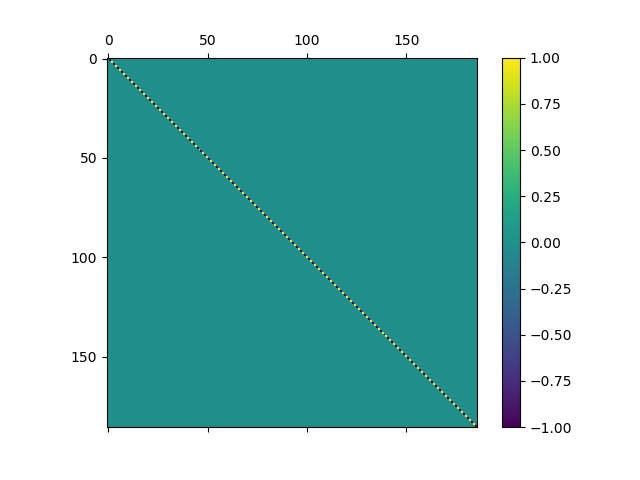

In [13]:
orto_fig,orto_axis=plt.subplots(num='Ortogonality Test')
orto_cax = orto_axis.matshow(np.real(G.T.dot(G)*(t[1]-t[0])))
orto_fig.colorbar(orto_cax)
orto_fig.show()

# Creating Test Data

Applying Cauchy noise to the test function.

<IPython.core.display.Javascript object>


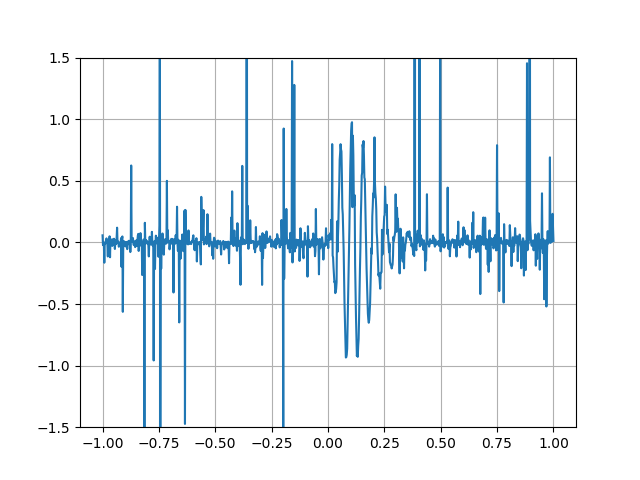

In [14]:
l = 0.02

u_noise = u+l*np.random.standard_cauchy(len(u))

noise_fig,noise_axes=plt.subplots(num='Noise')
noise_axes.plot(x,u_noise)
noise_axes.set_ylim(-1.5,1.5)
noise_axes.grid()
noise_fig.show()

# Filter Implementation

We define the functions that implement the filter.

In [15]:
def Steiner_Dihesion(u,N=100):
    eps2 = 0.75*(np.max(u)-np.min(u))**2
    u2 = u**2
    cntr=0
    while True:
        eps2p = eps2
        eps2 = 3*np.sum(u2/(eps2+u2)/np.sum(1/(eps2+u2)))
        cntr+=1
        if cntr > N or np.isclose(eps2p,eps2):
            break
    return eps2

$D$: Diagonal Matrix

$M$: Matrix

$d$: Vector of diagonal matrix elements

```python
np.allclose(M.dot(D),M*d) # Should be True
np.allclose(D.dot(M),(d*M.T).T) # Should be True
```

In [16]:
def Steiner_Filter_B(u,G,N=100):
    eps_sqr = Steiner_Dihesion(u)
    B = np.linalg.inv(G.T.dot(G)).dot(G.T.dot(u))
    cntr=0
    while True:
        Bp = np.copy(B)
        e_sqr = (u - np.real(G.dot(B)))**2
        W = eps_sqr/(eps_sqr+e_sqr)
        B = np.linalg.inv(G.T.dot( (W*G.T).T )).dot((G.T).dot(W*u))
        cntr+=1
        if cntr > N or np.allclose(Bp,B):
            break
    return B

In [17]:
def Steiner_Filter(u,G,N=100):
    return np.real(G.dot(Steiner_Filter_B(u,G,N)))

Let us examine the results of the filtering on our previously defined test data:

In [18]:
u_filt = Steiner_Filter(u_noise,G)

<IPython.core.display.Javascript object>


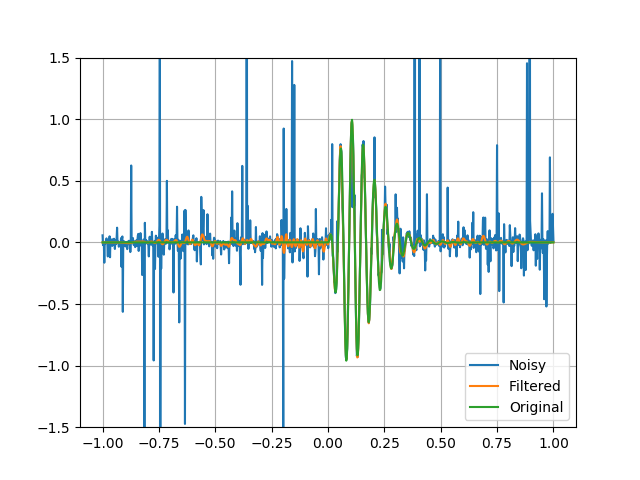

In [40]:
filter_fig,filter_axes=plt.subplots(num='Filter')
filter_axes.plot(x,u_noise)
filter_axes.plot(x,u_filt)
filter_axes.plot(x,u)
filter_axes.set_ylim(-1.5,1.5)
filter_axes.legend(['Noisy','Filtered','Original'])
filter_axes.grid()
filter_fig.show()

Where the $d[u_{\text{orig}},u_{\text{noise}}] =$

In [20]:
print(np.sqrt(np.mean((u-u_noise)**2)))

0.771844345285


And $d[u_{\text{orig}},u_{\text{filt}}]=$

In [21]:
print(np.sqrt(np.mean((u-u_filt)**2)))

0.0201498341856


Observing the results in frequency space:

In [22]:
fu_noise,f = math_fft(u_noise,x)
fu_filt,f = math_fft(u_filt,x)

<IPython.core.display.Javascript object>


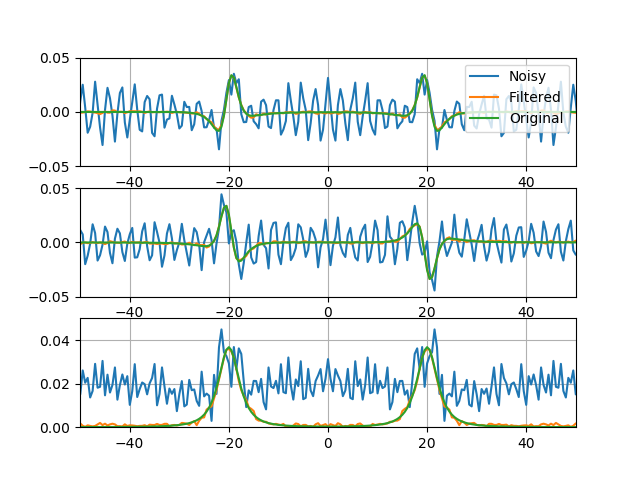

In [41]:
filter_fft_fig, filter_fft_axes=plt.subplots(3,num='Filter FFT')
filter_fft_axes[0].plot(f,np.real(fu_noise))
filter_fft_axes[0].plot(f,np.real(fu_filt))
filter_fft_axes[0].plot(f,np.real(fu))
filter_fft_axes[0].set_xlim([-50,50])
filter_fft_axes[0].set_ylim([-0.05,0.05])
filter_fft_axes[0].legend(['Noisy','Filtered','Original'])
filter_fft_axes[0].grid()
filter_fft_axes[1].plot(f,np.imag(fu_noise))
filter_fft_axes[1].plot(f,np.imag(fu_filt))
filter_fft_axes[1].plot(f,np.imag(fu))
filter_fft_axes[1].set_xlim([-50,50])
filter_fft_axes[1].set_ylim([-0.05,0.05])
filter_fft_axes[1].grid()
filter_fft_axes[2].plot(f,np.abs(fu_noise))
filter_fft_axes[2].plot(f,np.abs(fu_filt))
filter_fft_axes[2].plot(f,np.abs(fu))
filter_fft_axes[2].set_xlim([-50,50])
filter_fft_axes[2].set_ylim([0,0.05])
filter_fft_axes[2].grid()
filter_fft_fig.show()

# Implementing the algorithm for long data series

As matrix operations become increasingly unfeasable for long $u_k$ data series, we implement the algorithm with a sliding window operation. We chose the window function as the [Tukey window](https://en.wikipedia.org/wiki/Window_function#Tukey_window).

We utilize numpy's broadcasting feature during implementation.

In [24]:
def window(N,a=0.5):
    n = np.arange(N)
    ans = np.zeros(N)
    ans[0:np.int(a*(N-1)/2)] = 0.5*(1+np.cos(np.pi*(2*n[0:np.int(a*(N-1)/2)]/(a*(N-1))-1)))
    ans[np.int(a*(N-1)/2):np.int((N-1)*(1-a/2))+1] = 1
    if a != 0:
        ans[np.int((N-1)*(1-a/2))+1:N] = 0.5*(1+np.cos(np.pi*(2*n[np.int((N-1)*(1-a/2))+1:N]/(a*(N-1))-2/a-1)))
    return ans

<IPython.core.display.Javascript object>


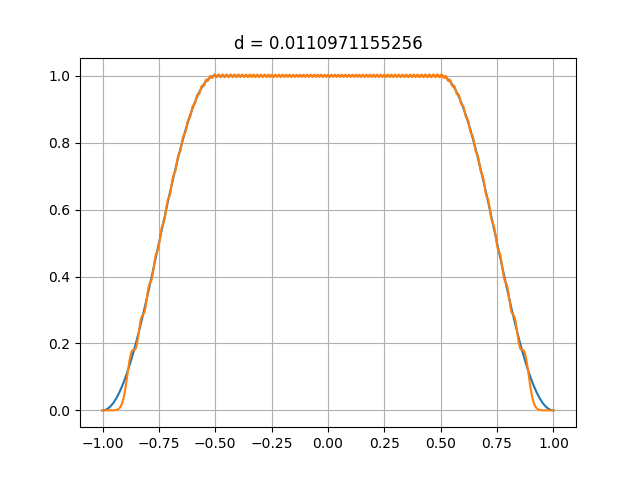

In [25]:
win_fig,win_axes=plt.subplots(num='Window')
def Window_Demo(a=0.5):
    win_axes.cla()
    w = window(len(x),a)
    w_filt = Steiner_Filter(w,G)
    win_axes.plot(x,w)
    win_axes.set_title("d = "+str(np.sqrt(np.mean((w-w_filt)**2))))
    win_axes.plot(x,w_filt)
    win_axes.grid()
    win_fig.show()

a_slider = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5)
w3=widgets.interactive(Window_Demo,a=a_slider)
display(w3)

In [26]:
def Steiner_Dihesion_Broadcast(u,N=100):
    eps2 = 0.75*(np.max(u,axis=1,keepdims=True)-np.min(u,axis=1,keepdims=True))**2
    u2 = u**2
    cntr=0
    while True:
        eps2p = eps2
        eps2 = 3*np.sum(u2/(eps2+u2),axis=1,keepdims=True)/np.sum(1/(eps2+u2),axis=1,keepdims=True)
        cntr+=1
        if cntr > N or np.allclose(eps2p,eps2):
            break
    return eps2

In [27]:
def Steiner_Filter_B_Broadcast(u,G,N=100):
    eps_sqr = Steiner_Dihesion_Broadcast(u)
    GTG = np.matmul(G.swapaxes(1,2),G)
    B = np.matmul(np.linalg.inv(np.matmul(G.swapaxes(1,2),G)),np.matmul(G.swapaxes(1,2),u))
    cntr=0
    while True:
        Bp = np.copy(B)
        e_sqr = (u - np.real(np.matmul(G,B)))**2
        W = eps_sqr/(eps_sqr+e_sqr)
        GTWG = np.matmul(G.swapaxes(1,2),(W.swapaxes(1,2)*G.swapaxes(1,2)).swapaxes(1,2) )
        B = np.matmul(np.linalg.inv(GTWG),
                      np.matmul((G.swapaxes(1,2)),(W*u)))
        cntr+=1
        if cntr > N or np.allclose(Bp,B):
            break
    return B

In [28]:
def Steiner_Filter_Broadcast(u,G,N=100):
    return np.real(np.matmul(G,Steiner_Filter_B_Broadcast(u,G,N)))

In [29]:
def Long_Steiner_Filter(u,G,N=100):
    slice_length = G.shape[0]
    w = window(slice_length).reshape(1,slice_length,1)
    Gb = G.reshape(1,G.shape[0],G.shape[1])
    num_slices = len(u) // slice_length
    u_slices0 = w*u.reshape(num_slices,slice_length,1)
    u_slices1 = w*np.roll(u,-slice_length//2).reshape(num_slices,slice_length,1)[0:-1]
    u_filt0 = Steiner_Filter_Broadcast(u_slices0,Gb,N)
    u_filt1 = Steiner_Filter_Broadcast(u_slices1,Gb,N)
    u_filt_first = u_filt0[0,:slice_length//4,0]
    if u_filt0.shape[0] > u_filt1.shape[0]:
        u_filt_last = u_filt0[-1,3*slice_length//4:,0]
    else:
        u_filt_last = u_filt1[-1,3*slice_length//4:,0]
    u_filt0 = u_filt0[:,slice_length//4:3*slice_length//4,0]
    u_filt1 = u_filt1[:,slice_length//4:3*slice_length//4,0]
    
    u_filt = np.copy(u_filt_first)
    for k in range(num_slices-1):
        u_filt = np.concatenate((u_filt,u_filt0[k],u_filt1[k]))
    
    if u_filt0.shape[0] > u_filt1.shape[0]:
        u_filt = np.concatenate((u_filt,u_filt0[-1],u_filt_last))
    else:
        u_filt = np.concatenate((u_filt,u_filt0[-1],u_filt1[-1],u_filt_last))
    
    return u_filt

In [30]:
x_long = np.linspace(-1,1,8*1024)
u_long = test_function(x_long)
u_long_noise = u_long+l*np.random.standard_cauchy(len(u_long))

In [31]:
u_long_filt = Long_Steiner_Filter(u_long_noise,G)

<IPython.core.display.Javascript object>


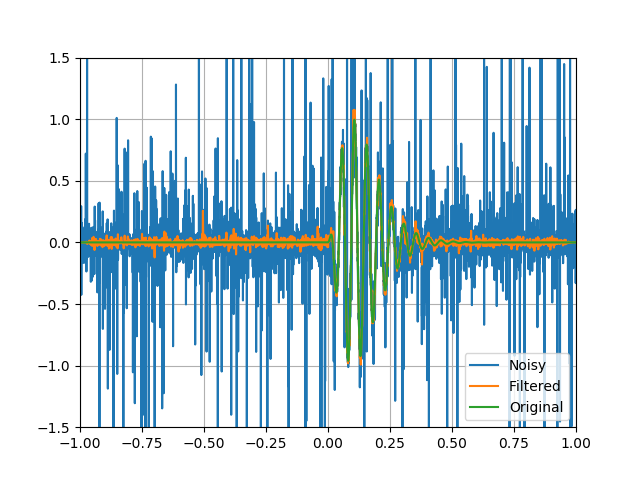

In [32]:
long_fig, long_axes = plt.subplots(num='Long filter results')
long_axes.plot(x_long,u_long_noise)
long_axes.plot(x_long,u_long_filt)
long_axes.plot(x_long,u_long)
long_axes.legend(['Noisy','Filtered','Original'])
long_axes.set_xlim(-1.,1.)
long_axes.set_ylim(-1.5,1.5)
long_axes.grid()
long_fig.show()

For the long case:

$d[u_{\text{orig}},u_{\text{noise}}] =$

In [33]:
print(np.sqrt(np.mean((u_long-u_long_noise)**2)))

72.4850294459


$d[u_{\text{orig}},u_{\text{filt}}]=$

In [34]:
print(np.sqrt(np.mean((u_long-u_long_filt)**2)))

0.0243048930227


Observing the results in frequency space

In [35]:
fu_long_noise,f_long = math_fft(u_long_noise,x_long)
fu_long_filt,f_long = math_fft(u_long_filt,x_long)
fu_long,f_long = math_fft(u_long,x_long)

<IPython.core.display.Javascript object>


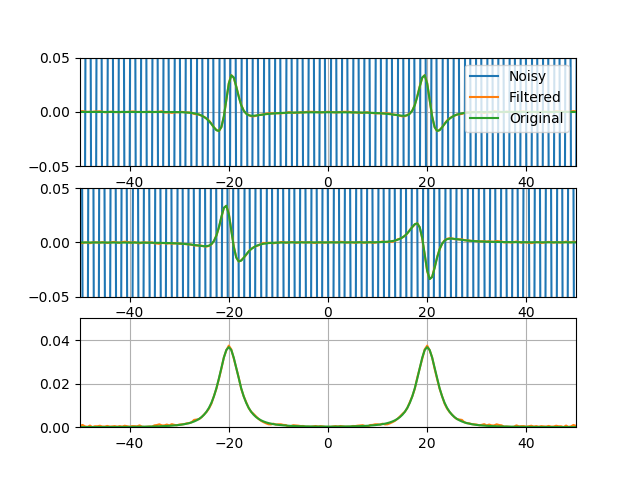

In [42]:
long_filter_fft_fig, long_filter_fft_axes=plt.subplots(3,num='Long Filter FFT')
long_filter_fft_axes[0].plot(f_long,np.real(fu_long_noise))
long_filter_fft_axes[0].plot(f_long,np.real(fu_long_filt))
long_filter_fft_axes[0].plot(f_long,np.real(fu_long))
long_filter_fft_axes[0].set_xlim([-50,50])
long_filter_fft_axes[0].set_ylim([-0.05,0.05])
long_filter_fft_axes[0].legend(['Noisy','Filtered','Original'])
long_filter_fft_axes[0].grid()
long_filter_fft_axes[1].plot(f_long,np.imag(fu_long_noise))
long_filter_fft_axes[1].plot(f_long,np.imag(fu_long_filt))
long_filter_fft_axes[1].plot(f_long,np.imag(fu_long))
long_filter_fft_axes[1].set_xlim([-50,50])
long_filter_fft_axes[1].set_ylim([-0.05,0.05])
long_filter_fft_axes[1].grid()
long_filter_fft_axes[2].plot(f_long,np.abs(fu_long_noise))
long_filter_fft_axes[2].plot(f_long,np.abs(fu_long_filt))
long_filter_fft_axes[2].plot(f_long,np.abs(fu_long))
long_filter_fft_axes[2].set_xlim([-50,50])
long_filter_fft_axes[2].set_ylim([0,0.05])
long_filter_fft_axes[2].grid()
long_filter_fft_fig.show()

# Further notes on optimization:

The filter could theoretically be made much more effiecient with the help of the Theano library, to utilize GPU parallel processing. However, after a short bit of experimentation, it turns out that [theano.tensor.nlinalg.MatrixInverse](http://deeplearning.net/software/theano/library/tensor/nlinalg.html#theano.tensor.nlinalg.MatrixInverse) (along with other linear algebra operations in the documentation) do not support operations on multiple matrices as [numpy's implementation](https://docs.scipy.org/doc/numpy-1.12.0/reference/routines.linalg.html#linear-algebra-on-several-matrices-at-once) does.

This means that even if we would implement a Theano version anyway, it would probably not recieve as much of a of a speed increase because we would have to scan sequentially over the matrices for matrix inversion.